In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r'C:\Users\nacho\OneDrive - University of Birmingham\DATA SCIENCE\Summer Project\all_player_data.csv'
df = pd.read_csv(file_path)

centerbacks = df[df['position'].str.lower() == 'center back']

C:\Users\nacho\anaconda\envs\notebook-6.1.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



✅ Best UMAP + KMeans config for Center Backs:
n_neighbors=5, min_dist=0.0, k=5, silhouette=0.443


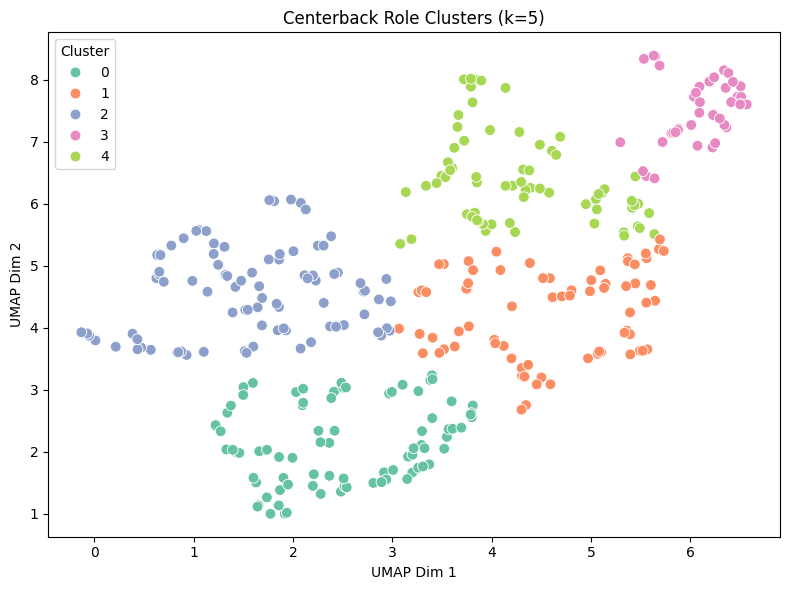

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
df["projected_y"] = df["average_position_y"].apply(
    lambda y: 80 - y if y < 40 else y)
    
# Target position to analyze
target_position = 'center back'

# Filter for CBs
group = df[df["position"].str.lower() == target_position.lower()].copy()

# Features tailored for center backs
usable_features = [
    # Passing
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    'progressive_pass_accuracy', 'long_passes_per_90', 'long_pass_accuracy', 'key_passes_per_90',
    'passes_received_per_90',
    # Dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 'dribbles_per_90', 'dribble_success_rate',
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', 'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Physicality
    'duels_per_90', 'duels_won_per_90', 'duel_success_rate',
    'fouls_made_per_90', 
    'headers_per_90', 'shots_per_90',

    # Positioning
    'touches_per_90', 'average_position_x','projected_y' #'average_position_y',
]

# Drop NA rows
X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
    exit()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Grid search UMAP params + KMeans clustering
best_result = {'score': -1}

for n_neighbors in [ 5, 10, 15, 30, 50]:
    for min_dist in [0.0, 0.05, 0.1, 0.2]:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_scaled)

        for k in range(3, 8):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_umap)
            score = silhouette_score(X_umap, labels)

            if score > best_result['score']:
                best_result = {
                    'n_neighbors': n_neighbors,
                    'min_dist': min_dist,
                    'k': k,
                    'score': score,
                    'X_umap': X_umap,
                    'labels': labels
                }

# Display best result
print(f"\n✅ Best UMAP + KMeans config for Center Backs:")
print(f"n_neighbors={best_result['n_neighbors']}, min_dist={best_result['min_dist']}, k={best_result['k']}, silhouette={best_result['score']:.3f}")

# Final cluster plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=best_result['X_umap'][:, 0],
    y=best_result['X_umap'][:, 1],
    hue=best_result['labels'],
    palette='Set2',
    s=60
)
plt.title(f"Centerback Role Clusters (k={best_result['k']})")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [3]:
# Assign cluster labels to the original data
group = group.loc[X.index].copy()  # Align index with X
group["cluster"] = best_result["labels"]

# Compute mean stats per cluster
cluster_means = group.groupby("cluster")[usable_features].mean().round(3)

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')


=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0               21.591         76.160                      7.372   
1               28.736         83.098                      8.415   
2               23.603         78.803                      7.364   
3               44.014         87.495                     12.441   
4               31.418         82.227                      9.625   

         progressive_pass_accuracy  long_passes_per_90  long_pass_accuracy  \
cluster                                                                      
0                           51.853               4.034              35.659   
1                           61.669               4.016              43.291   
2                           55.812               3.739              37.571   
3                           70.923               4.595              46.146   
4                    

In [4]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}")



Cluster 0:
Player: 7, Name: Ángel Trujillo Canorea
Player: 8, Name: Zouhair Feddal
Player: 16, Name: Mauro Javier Dos Santos
Player: 17, Name: Aleksandar Pantić
Player: 43, Name: Timothée Kolodziejczak
Player: 60, Name: Alejandro Arribas Garrido
Player: 85, Name: Raúl Albentosa Redal
Player: 94, Name: Carl Medjani
Player: 106, Name: Álvaro González Soberón
Player: 107, Name: Enzo Pablo Roco Roco
Player: 109, Name: Óscar Esau Duarte Gaitán
Player: 113, Name: Jon Ansotegi Gorostola
Player: 132, Name: Luis Hernández Rodríguez
Player: 145, Name: Víctor Ruíz Torre
Player: 156, Name: Antonio Amaya Carazo
Player: 163, Name: David Navarro Pedrós
Player: 170, Name: Germán Alejandro Pezzella
Player: 197, Name: Adil Rami
Player: 202, Name: Carlos Gurpegi Nausia
Player: 223, Name: Stefan Savić
Player: 258, Name: Mikel González de Martín Martínez
Player: 269, Name: José María Giménez de Vargas
Player: 271, Name: Iván Ramis Barrios
Player: 274, Name: Emiliano Daniel Velázquez Maldonado
Player: 286,

In [5]:
# Reassign roles directly based on cluster label
role_map = {
    0: "Stopper",
    1: "Sweeper",
    2: "Enforcer",
    3: "Libero",
    4: "Ball Playing CB",
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_result["labels"]]

In [6]:
group.head()


,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,projected_y,cluster,role
1,26023,Juan Francisco García García,2249.52,Left Center Back,center back,30.606529,64.705882,15.363277,50.781250,10.002134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.167520,4,Ball Playing CB
7,25824,Ángel Trujillo Canorea,1033.83,Right Center Back,center back,16.540437,76.842105,5.484461,53.968254,2.350483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.268089,0,Stopper
8,6647,Zouhair Feddal,3961.93,Left Center Back,center back,25.828321,74.582234,11.153655,55.193483,6.746712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.511877,0,Stopper
16,6837,Mauro Javier Dos Santos,4222.12,Right Center Back,center back,20.911296,67.074414,8.846267,44.819277,5.712770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.095394,0,Stopper
17,27239,Aleksandar Pantić,2652.37,Left Center Back,center back,17.983916,63.773585,7.329294,40.740741,4.071830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.072038,0,Stopper


In [7]:
final = group.drop(columns = ['cluster', 'projected_y'])
final.head()

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,collections_per_90,punches_per_90,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,role
1,26023,Juan Francisco García García,2249.52,Left Center Back,center back,30.606529,64.705882,15.363277,50.781250,10.002134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ball Playing CB
7,25824,Ángel Trujillo Canorea,1033.83,Right Center Back,center back,16.540437,76.842105,5.484461,53.968254,2.350483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stopper
8,6647,Zouhair Feddal,3961.93,Left Center Back,center back,25.828321,74.582234,11.153655,55.193483,6.746712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stopper
16,6837,Mauro Javier Dos Santos,4222.12,Right Center Back,center back,20.911296,67.074414,8.846267,44.819277,5.712770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stopper
17,27239,Aleksandar Pantić,2652.37,Left Center Back,center back,17.983916,63.773585,7.329294,40.740741,4.071830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stopper


In [8]:
final.to_csv('cb_roles.csv', index=False)